## Descrição do problema

Os cartões de crédito são utilizados na indústria financeira para prever a probabilidade de inadimplência e orientar a emissão de cartões de crédito. Esses scores de crédito dependem dos dados pessoais dos candidatos e de informações históricas, quantificando o risco de maneira objetiva.

Este projeto tem como objetivo criar um modelo de Classificador de Floresta Aleatória (Random Forest) para ajudar os bancos a decidir quem deve receber um cartão de crédito.

## Carregando Bibliotecas

In [1]:
# Carregando bibliotecas
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report, f1_score, precision_score, recall_score

## Descrição das colunas do conjuto de dados "application record"

| Nome do recurso          | Explicação                          | Observações                                                                 |
|--------------------------|-------------------------------------|-----------------------------------------------------------------------------|
| ID                       | Número do cliente                   |                                                                             |
| CODE_GENDER              | Gênero                              |                                                                             |
| FLAG_OWN_CAR             | Tem um carro                        |                                                                             |
| FLAG_OWN_REALTY          | Existe uma propriedade              |                                                                             |
| CNT_CHILDREN             | Número de crianças                  |                                                                             |
| AMT_INCOME_TOTAL         | Renda anual                         |                                                                             |
| NAME_INCOME_TYPE         | Categoria de renda                  |                                                                             |
| NAME_EDUCATION_TYPE      | Nível de educação                   |                                                                             |
| NAME_FAMILY_STATUS       | Estado civil                        |                                                                             |
| NAME_HOUSING_TYPE        | Modo de vida                        |                                                                             |
| DAYS_BIRTH               | Aniversário                         | Contagem regressiva a partir do dia atual (0), -1 significa ontem           |
| DAYS_EMPLOYED            | Data de início do emprego           | Contagem regressiva a partir do dia atual (0). Se positivo, significa que a pessoa está atualmente desempregada. |
| FLAG_MOBIL               | Existe um telefone celular?         |                                                                             |
| FLAG_WORK_PHONE          | Existe um telefone de trabalho?     |                                                                             |
| FLAG_PHONE               | Tem algum telefone?                 |                                                                             |
| FLAG_EMAIL               | Existe um e-mail                    |                                                                             |
| OCCUPATION_TYPE          | Ocupação                            |                                                                             |
| CNT_FAM_MEMBERS          | Tamanho da família                  |                                                                             |


# Carregando conjunto de dados application record

In [2]:
# Carregando o conjuto de dados
df_application = pd.read_csv('../data/application_record.csv')

# Pré-visualizando conjunto de dados
df_application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
# Conhecendo o conjuto de dados aplplication record 
print('Visualizando quantidade de linhas do conjunto de dados application record:', df_application.shape[0])

print('Visualizando quantidade de colunas do conjunto de dados application record:', df_application.shape[1])

Visualizando quantidade de linhas do conjunto de dados application record: 438557
Visualizando quantidade de colunas do conjunto de dados application record: 18


In [4]:
# Visualizando tipos de dados
df_application.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
dtype: object

### Observações

* O conjunto de dados application record possuí 438557 linhas e 18 colunas
* O conjunto contém um total de 10 colunas numéricas
* O conjuto contém 8 colunas object

## Descrição das colunas do conjunto de dados "credit record"

| Nome do Recurso   | Explicação  | Observações |
|------------------|------------|-------------|
| ID              | Número do cliente | |
| MONTHS_BALANCE | Mês recorde | O mês dos dados extraídos é o ponto de partida, para trás, 0 é o mês atual, -1 é o mês anterior e assim por diante |
| STATUS         | Status | 0: 1-29 dias em atraso <br> 1: 30-59 dias em atraso <br> 2: 60-89 dias em atraso <br> 3: 90-119 dias em atraso <br> 4: 120-149 dias em atraso <br> 5: Dívidas vencidas ou inadimplentes, amortizações por mais de 150 dias <br> C: Quitadas naquele mês <br> X: Nenhum empréstimo no mês |


# Carregando conjunto de dados credit record

In [5]:
# Carregando conjunto de dados
df_credit = pd.read_csv('../data/credit_record.csv')

# Pré-visualizando conjunto de dados
df_credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
print('Visualizando quantidade de linhas do conjunto de dados credit record:', df_credit.shape[0])

print('Visualizando quantidade de colunas do conjunto de dados credit record:', df_credit.shape[1])

Visualizando quantidade de linhas do conjunto de dados credit record: 1048575
Visualizando quantidade de colunas do conjunto de dados credit record: 3


In [7]:
# Visualizando tipos de dados
df_credit.dtypes

ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

### Observações

* O conjunto de dados credit record possuí 1048575 linhas e 3 colunas
* O conjunto contém um total de 2 colunas numéricas
* O conjuto contém 1 coluna object que mostra o status dos detalhes da cobrança do cartão de credito

# Mesclando ambos os conjuntos de dado(Base de ID comum)

In [8]:
# Mesclando ambos os dataframe com base no ID

df = pd.merge(df_application, df_credit, on='ID', how='inner')

* Mesclei os dois dataframes com base na coluna ID presente em ambos os conjuntos de dados.
* Além disso, o conjunto de dados Credit record tem mais registros de clientes do que o conjunto de dados Application record, então garantimos que nosso novo dataframe df contenha apenas as linhas que têm o mesmo número de ID
* Para esse propósito, usei o parâmetro inner na função pd.merge

In [9]:
# Pré-visualizando o novo conjunto

df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


In [10]:
# verificando a forma do novo dataframe

print('Visualizando quantidade de linhas do novo dataframe:', df.shape[0])
print('Visualizando quantidade de colunas do novo dataframe:', df.shape[1])

Visualizando quantidade de linhas do novo dataframe: 777715
Visualizando quantidade de colunas do novo dataframe: 20


### Observações

* Anteriormente, vi que o conjunto de dados do application record tem 438557 linhas
* Agora o conjunto de dados mesclado contém apenas 777715
* Isso significa que o conjunto de dados do application record e credit record tem apenas 777715 linhas com números de ID comuns

# Verificando valores ausentes e lidando com eles

In [11]:
# Verificando valores nulos

df.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        240048
CNT_FAM_MEMBERS             0
MONTHS_BALANCE              0
STATUS                      0
dtype: int64

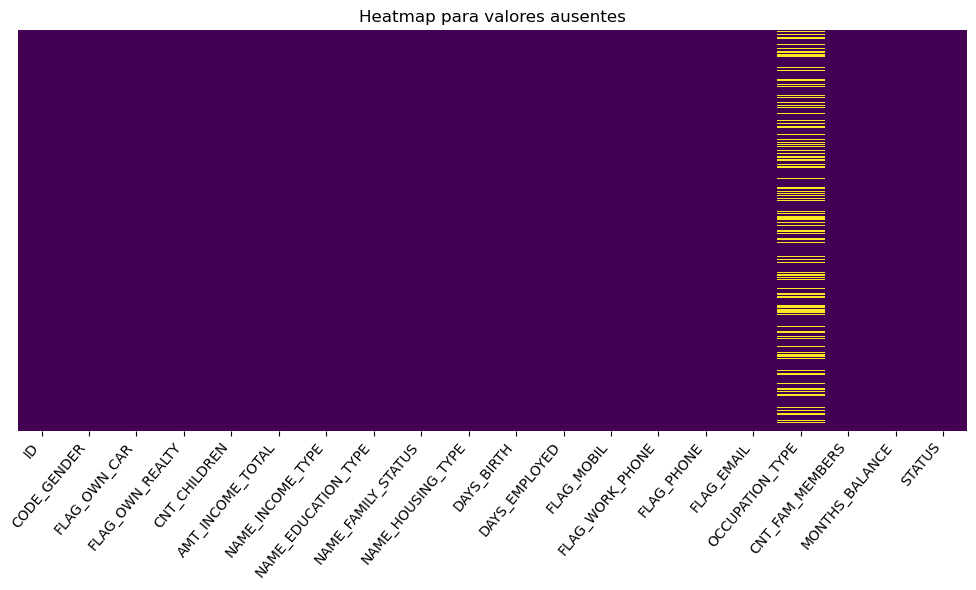

In [12]:
# Definindo tamanho da figura
plt.figure(figsize=(10,6))

# Plotando o mapa de calor para valores ausentes
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

# Definindo o título
plt.title('Heatmap para valores ausentes')

# Ajustando os rótulos do eixo X para espaçamento uniforme
plt.xticks(rotation=50, ha='right')  
plt.tight_layout()

# Exibindo o gráfico
plt.show()


In [13]:
# Checando o percentual de valores ausentes na coluna "OCCUPATION_TYPE"

df['OCCUPATION_TYPE'].isnull().sum()/df.shape[0]*100

np.float64(30.86580559716606)

### Observações

* O dataframe possuí apenas uma coluna com valores ausentes
* A coluna "OCCUPATION_TYPE" possuí um total de 240048 valores ausentes um percentual de 30.86%
* Optarei por remover a coluna OCCUPATION_TYPE do dataframe por possuir um alto percental de valores ausentes e cada pessoa tem seu próprio registro exclusivo. E não posso colocar imputar os valores ausentes com o modo

In [14]:
# Removendo a coluna
df.drop('OCCUPATION_TYPE', axis=1, inplace=True)

# Cofirmando resultado
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

# Checando a quantidade de valores únicos no dataframe 

In [15]:
df.nunique()

ID                     36457
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
CNT_CHILDREN               9
AMT_INCOME_TOTAL         265
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH              7183
DAYS_EMPLOYED           3640
FLAG_MOBIL                 1
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
CNT_FAM_MEMBERS           10
MONTHS_BALANCE            61
STATUS                     8
dtype: int64

### Observações

* O conjunto de dados possuí um total de 777515 linhas, mas existe apenas 36457 registro únicos na coluna ID
* Isso mostra que o conjunto de dados pode ter algumas duplicatas 

# Verficando duplicatas

In [16]:
# Verificando duplicatas

df.duplicated().sum()

np.int64(0)

In [17]:
df[df['ID'].duplicated()].head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-4,C
5,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-5,C
6,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-6,C
7,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-7,C
8,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-8,C
9,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-9,C
10,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-10,C


In [18]:
df[df['ID'].duplicated()].tail(20)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
777694,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-3,0
777695,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-4,0
777696,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-5,0
777697,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-6,0
777698,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-7,0
777699,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-8,0
777700,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-9,0
777702,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,1.0,-1,0
777703,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,1.0,-2,0
777704,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,1.0,-3,0


### Observações

* Após essa verficição com base no número de entrandas únicas na coluna ID constatei que existem 36457 dados de clientes
* E também não há duplicatas no conjunto de dados de 36457 ID que são coletados com base em diferentes meses de MONTHS_BALANCE

# Renomeando colunas

In [19]:
# Verificando colunas
df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

In [20]:
# Renomeando colunas
df.rename(columns={
  'CODE_GENDER' : 'gender',
  'FLAG_OWN_CAR':'owns_car',
  'FLAG_OWN_REALTY' : 'owns_property',
  'CNT_CHILDREN' : 'num_children',
  'AMT_INCOME_TOTAL': 'total_income',
  'NAME_INCOME_TYPE': 'income_type',
  'NAME_EDUCATION_TYPE': 'education_level',
  'NAME_FAMILY_STATUS': 'family_status',
  'NAME_HOUSING_TYPE': 'housing_type' ,
  'DAYS_BIRTH': 'age_in_days',
  'DAYS_EMPLOYED': 'employment_in_days',
  'FLAG_MOBIL': 'mobile',
  'FLAG_WORK_PHONE': 'work_phone',
  'FLAG_PHONE': 'phone',
  'FLAG_EMAIL': 'email',
  'CNT_FAM_MEMBERS': 'family_members',
  'MONTHS_BALANCE': 'months_balance',
  'STATUS': 'status'
}, inplace= True), 

(None,)

In [21]:
df.columns

Index(['ID', 'gender', 'owns_car', 'owns_property', 'num_children',
       'total_income', 'income_type', 'education_level', 'family_status',
       'housing_type', 'age_in_days', 'employment_in_days', 'mobile',
       'work_phone', 'phone', 'email', 'family_members', 'months_balance',
       'status'],
      dtype='object')

In [22]:
# verificando colunas com tipo de object

df.select_dtypes(include='object').columns

Index(['gender', 'owns_car', 'owns_property', 'income_type', 'education_level',
       'family_status', 'housing_type', 'status'],
      dtype='object')

In [23]:
# Verificando valores unicos de algumas colunas

col = ['gender', 'owns_car', 'owns_property']

for i in col:
    print(f'{df[i].value_counts()}')

gender
F    518851
M    258864
Name: count, dtype: int64
owns_car
N    473355
Y    304360
Name: count, dtype: int64
owns_property
Y    512948
N    264767
Name: count, dtype: int64


In [24]:
# mapeando os valores em algumas colunas

# mapeando entradas únicas de gender, owns_car e owns_property
df['gender'] = df['gender'].map({'F':'female', 'M': 'male'})
df['owns_car'] = df['owns_car'].map({'N': 'no', 'Y': 'yes'})
df['owns_property'] = df['owns_property'].map({'N': 'no', 'Y': 'yes'})

In [25]:
# checando valores únicos na coluna status

df['status'].value_counts()

status
C    329536
0    290654
X    145950
1      8747
5      1527
2       801
3       286
4       214
Name: count, dtype: int64

In [26]:
# mapeando os valores na coluna de status e armazenando o resultado na nova coluna
df['loan_status'] = df['status'].map({'0': 'first_month_due' , '1': '2nd_month_due', '2' : '3rd_month_overdue',  '3': '4th_month_overdue', '4' : '5th_month_overdue', '5' : 'bad_debt' , 'C': 'good' , 'X' : 'no_loan'})

In [27]:
# Corfimação do resultado
df.columns.values

array(['ID', 'gender', 'owns_car', 'owns_property', 'num_children',
       'total_income', 'income_type', 'education_level', 'family_status',
       'housing_type', 'age_in_days', 'employment_in_days', 'mobile',
       'work_phone', 'phone', 'email', 'family_members', 'months_balance',
       'status', 'loan_status'], dtype=object)

# Análise exploratória de dados

#### Objetivo

* O principal objetivo é obter ideias sobre os diferentes atributos dos clientes.
* Obter uma visão geral da distribuição dos dados.
* Obter uma visão geral do relacionamento entre os atributos.
* Particularmente, obter uma visão geral do relacionamento entre os atributos e a variável alvo [loan_status].

##### Checando a distribuição de [gender , owns_car,  owns_property , income_type]

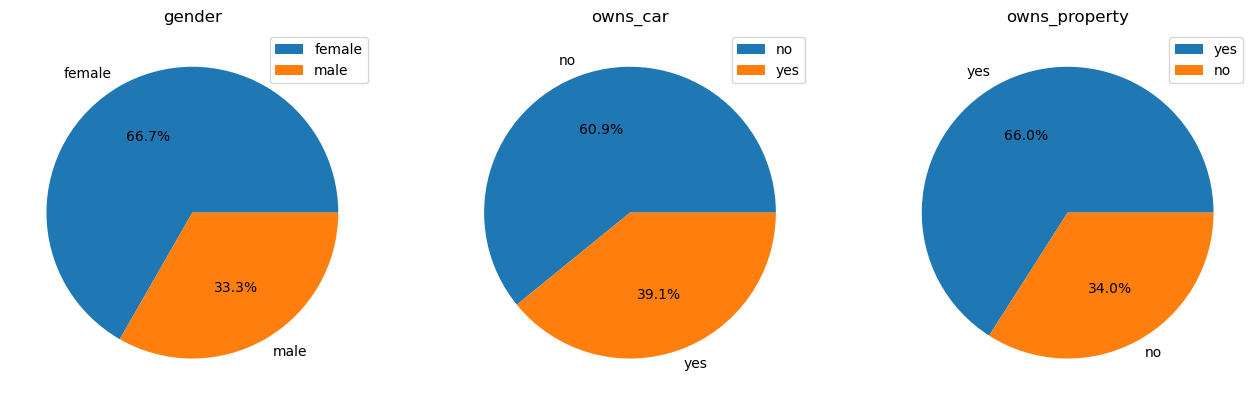

In [28]:
dist_col = ['gender', 'owns_car', 'owns_property']

plt.figure(figsize=(16,9))

for i in range(len(dist_col)):
  plt.subplot(1, 3, i+1)
  plt.title(dist_col[i])
  
  counts = df[dist_col[i]].value_counts()
  plt.pie(counts, labels=counts.index, autopct='%1.1f%%'  )
  
  plt.legend(counts.index)
plt.show()

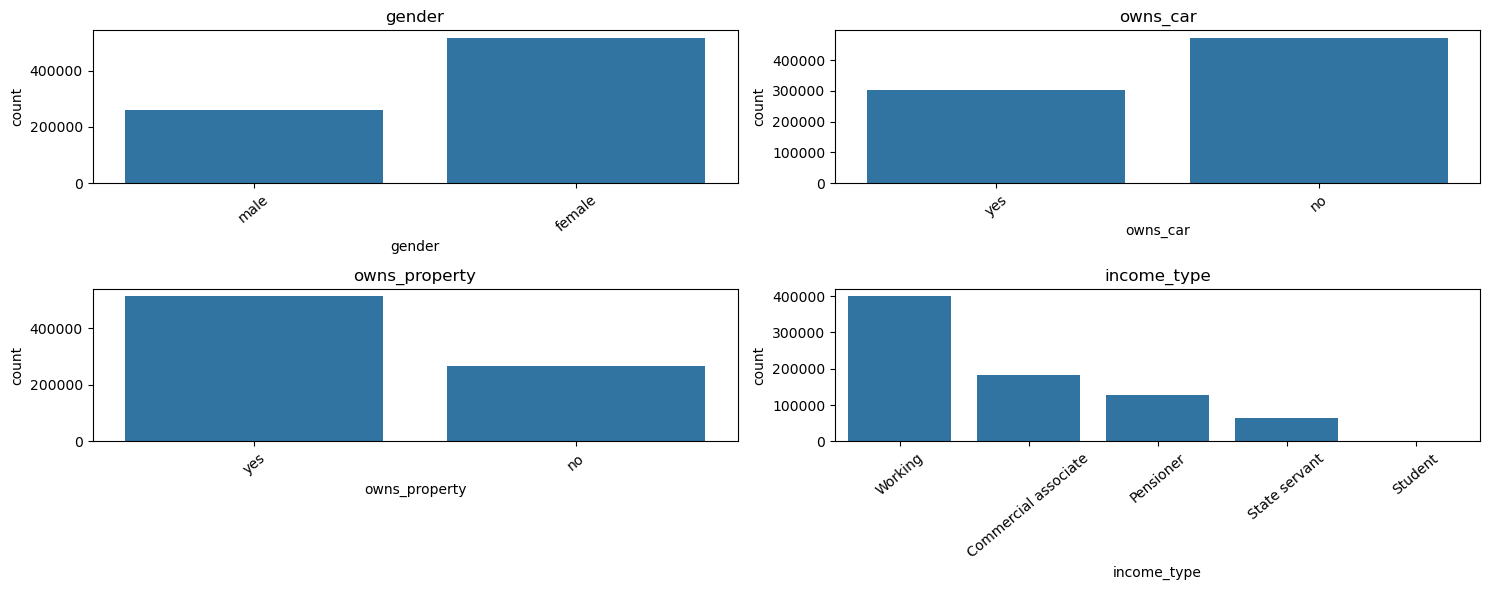

In [29]:
dist_col_2 = ['gender', 'owns_car', 'owns_property', 'income_type',]

plt.figure(figsize=(15, 6))

for i in range(len(dist_col_2)):
  plt.subplot(2, 2, i+1)
  plt.title(dist_col_2[i])
  sns.countplot(data=df, x=df[dist_col_2[i]])
  plt.xticks(rotation=40)
  
plt.tight_layout()
plt.show()

### Observações

* Existem mais clientes mulheres do que homens no dataframe
* O número de clientes que não têm carro é maior do que o número de clientes que têm carro
* Mais clientes têm propriedade própria

In [30]:
# verificando a contagem do status do empréstimo
df['loan_status'].value_counts()

loan_status
good                 329536
first_month_due      290654
no_loan              145950
2nd_month_due          8747
bad_debt               1527
3rd_month_overdue       801
4th_month_overdue       286
5th_month_overdue       214
Name: count, dtype: int64

### Observações

* Maior parte dos clientes do conjunto de dados pagou o emprestimo daquele mês
* o empréstimo do primeiro mês devido e nenhum empréstimo no mês ficam em 2º e 3º lugar, respectivamente, em termos de contagem de valor
* 1527 clientes têm dívidas inadimplentes

##### Obtendo insights sobre o status do empréstimo versus gênero

###### plotagem de contagem de gráfico de status de empréstimo x gênero

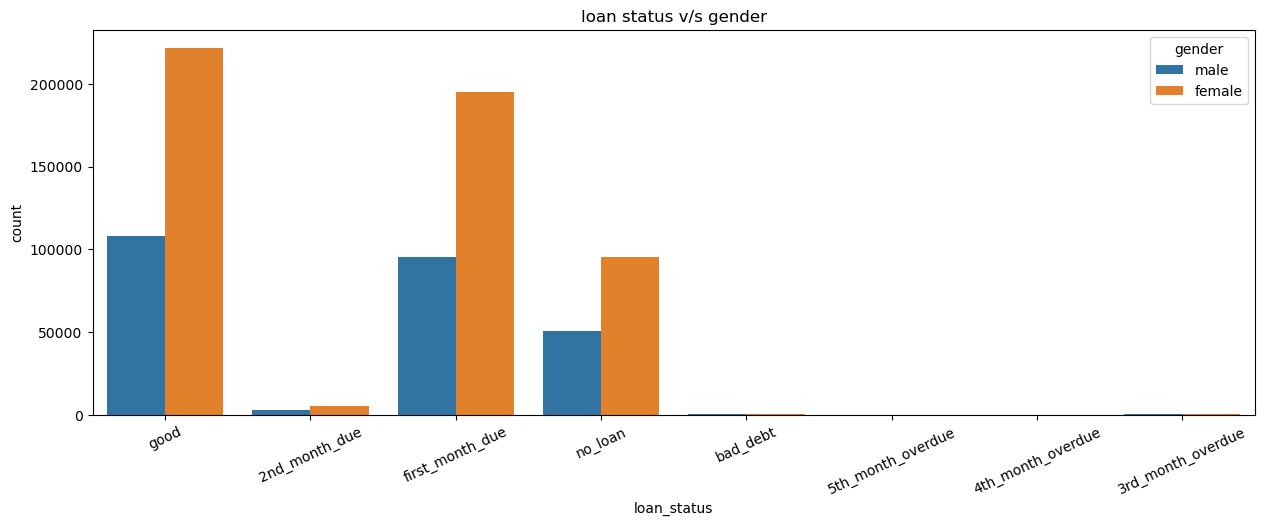

In [31]:
plt.figure(figsize=(15, 5))

sns.countplot(data=df, x=df['loan_status'], hue=df['gender'])
plt.title('loan status v/s gender')
plt.xticks(rotation=25)
plt.show()

In [32]:
filtered_loan = df.groupby('loan_status')['gender'].value_counts()

filtered_loan[filtered_loan<10000].unstack()

gender,female,male
loan_status,,
2nd_month_due,5530,3217
3rd_month_overdue,510,291
4th_month_overdue,178,108
5th_month_overdue,128,86
bad_debt,809,718


<Figure size 1500x900 with 0 Axes>

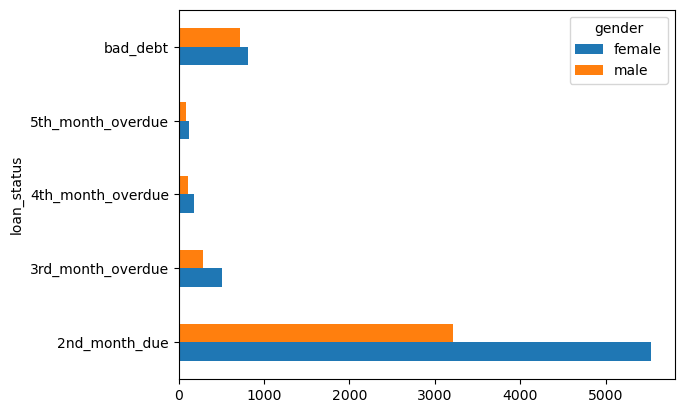

In [33]:
filtered_loan = df.groupby('loan_status')['gender'].value_counts()

plt.figure(figsize=(15, 9))

filtered_loan[filtered_loan<10000].unstack().plot(kind='barh')

plt.show()

#### Observações

* Como o conjunto de dados tem mais mulheres do que homens, a contagem de mulheres é maior do que a contagem de homens que pagaram o empréstimo daquele mês e não têm empréstimo naquele mês.
* Além disso, as mulheres têm mais dívidas vencidas e inadimplentes do que os homens.

#### verificando contagem de valores de income_types

In [34]:
df['income_type'].value_counts()

income_type
Working                 400164
Commercial associate    183385
Pensioner               128392
State servant            65437
Student                    337
Name: count, dtype: int64

##### verificando a relação entre income_type e gender

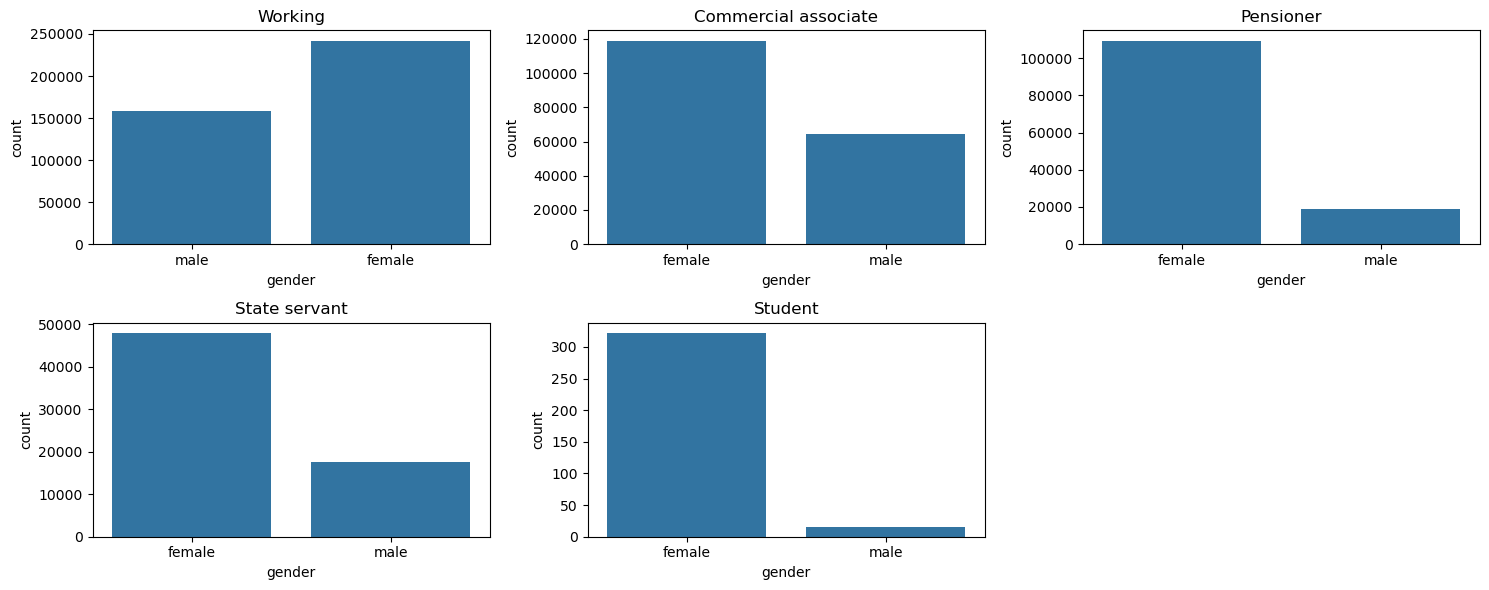

In [35]:
count = df['income_type'].value_counts()

plt.figure(figsize=(15, 6))

for i in range(len(count)):
    plt.subplot(2, 3, i+1)
    plt.title(count.index[i])  
    sns.countplot(data=df[df['income_type'] == count.index[i]], x='gender')

plt.tight_layout()
plt.show()

#### Observações

* No tipo de renda associada de Working e Commercial associate, o número de clientes do sexo masculino é metade do número de clientes do sexo feminino
* Enquanto que, em income_type = Pensioner e Student, o número de clientes de ATM do sexo masculino é muito menor em comparação com o do sexo feminino

##### Verificando a relação entre loan status e income type

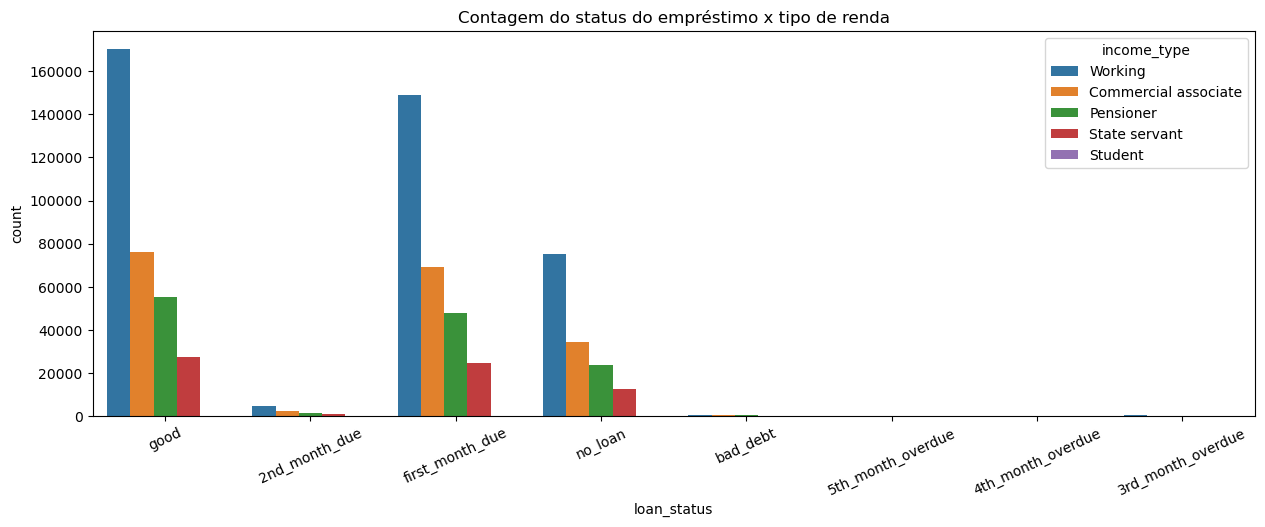

In [36]:
plt.figure(figsize=(15, 5))

sns.countplot(data=df, x=df['loan_status'], hue=df['income_type'])

plt.title('Contagem do status do empréstimo x tipo de renda')
plt.xticks(rotation=25)
plt.show()

#### Observações 

* A maioria dos clientes com tipo de renda ativa pagou o empréstimo daquele mês
* Uma tendência semelhante pode ser observada nas categorias de renda, como first_month_due e no_loan_for_month. A categoria de trabalhadores está no topo da lista, seguida por commercial associates & pensioners.

In [37]:
count = df.groupby('gender')[['income_type' , 'loan_status']].value_counts()

count[count<1000].unstack()

loan_status                  2nd_month_due  3rd_month_overdue  \
gender income_type                                              
female Commercial associate            NaN              117.0   
       Pensioner                     950.0              143.0   
       State servant                 592.0               26.0   
       Student                         NaN                NaN   
       Working                         NaN              224.0   
male   Commercial associate          883.0               70.0   
       Pensioner                     207.0               30.0   
       State servant                 175.0               13.0   
       Student                         1.0                NaN   
       Working                         NaN              178.0   

loan_status                  4th_month_overdue  5th_month_overdue  bad_debt  \
gender income_type                                                            
female Commercial associate               47.0               45.0     284.0   
       Pensioner                          66.0               35.0     252.0   
       State servant                      12.0                6.0      47.0   
       Student                             NaN                NaN       NaN   
       Working                            53.0               42.0     226.0   
male   Commercial associate               30.0               27.0     277.0   
       Pensioner                          14.0                9.0      61.0   
       State servant                       5.0                2.0      14.0   
       Student                             NaN                NaN       NaN   
       Working                            59.0               48.0     366.0   

loan_status                  first_month_due   good  no_loan  
gender income_type                                            
female Commercial associate              NaN    NaN      NaN  
       Pensioner                         NaN    NaN      NaN  
       State servant                     NaN    NaN      NaN  
       Student                          57.0  196.0     69.0  
       Working                           NaN    NaN      NaN  
male   Commercial associate              NaN    NaN      NaN  
       Pensioner                         NaN    NaN      NaN  
       State servant                     NaN    NaN      NaN  
       Student                          10.0    4.0      NaN  
       Working                           NaN    NaN      NaN

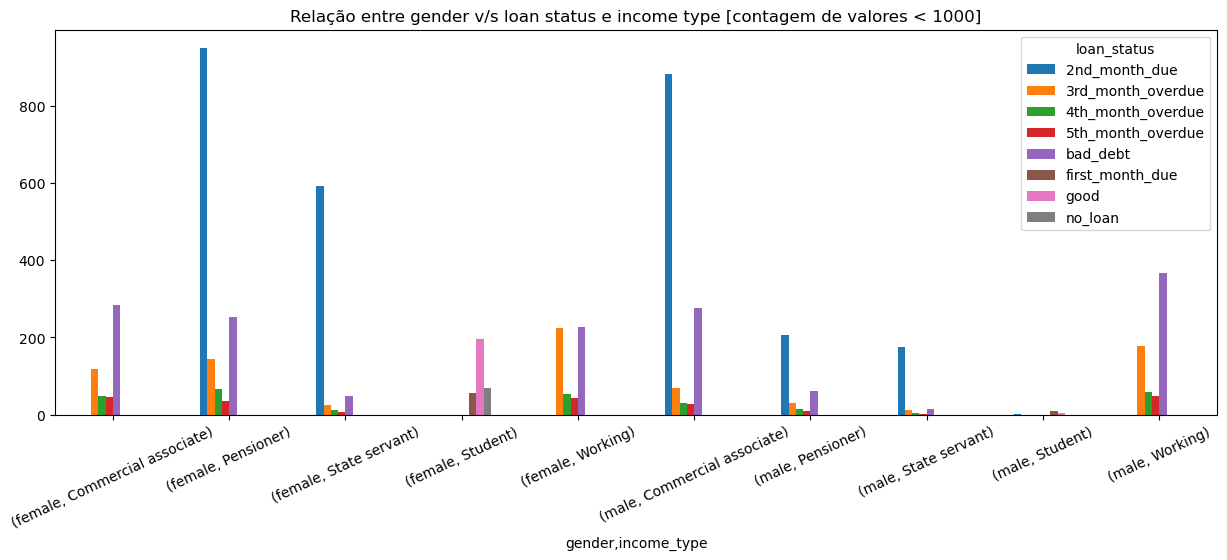

In [38]:
count = df.groupby('gender')[['income_type', 'loan_status' ]].value_counts()

count[count<1000].unstack().plot(kind='bar' , figsize=(15, 5) , legend=True )
plt.title('Relação entre gender v/s loan status e income type [contagem de valores < 1000]')
plt.xticks(rotation=25)
plt.show()

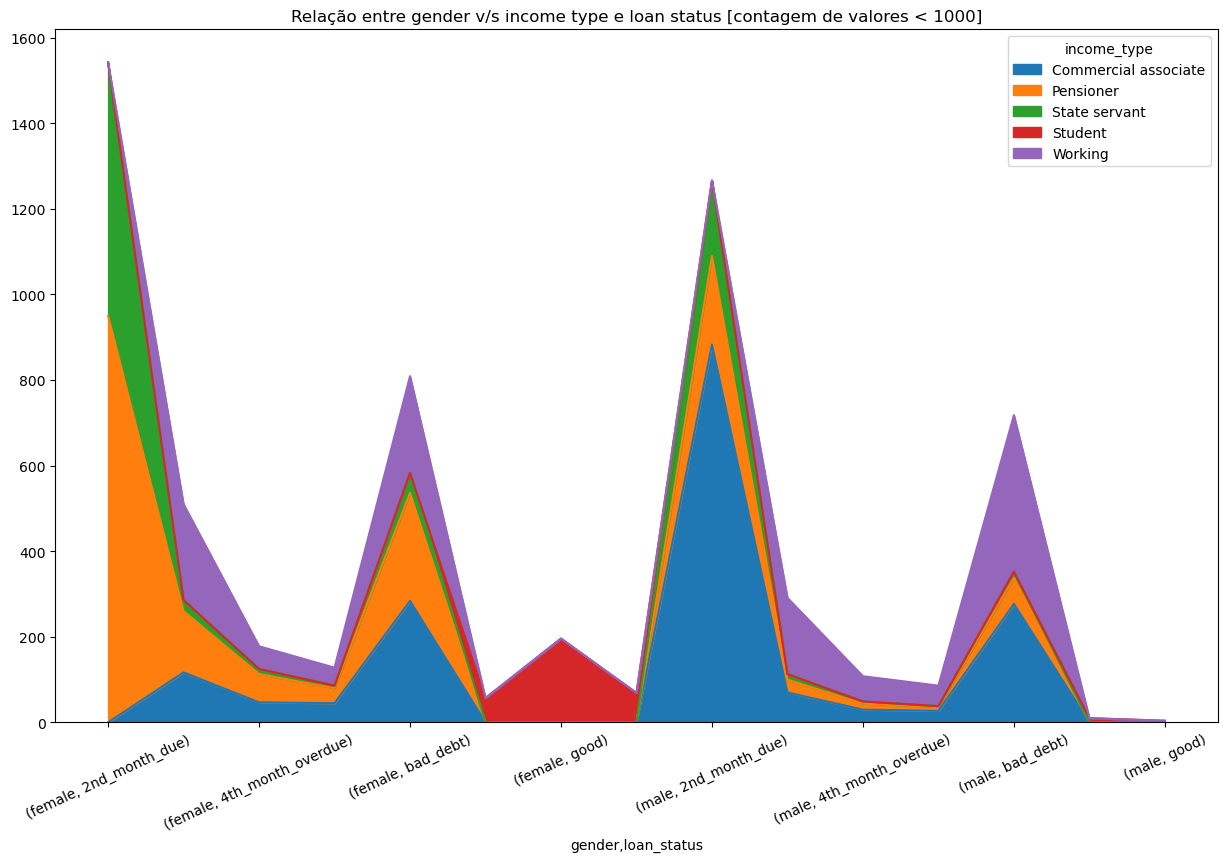

In [39]:
count = df.groupby('gender')[['loan_status','income_type']].value_counts()
count[count<1000].unstack().plot(kind='area' , figsize=(15, 9)) 
plt.title('Relação entre gender v/s income type e loan status [contagem de valores < 1000]')
plt.xticks(rotation=25)
plt.show()

#### Observações

* Quando analisamos as tendências de loan_status em termos de income_type e gender, podemos ver que os homens com student em income_type não possuem empréstimos para aquele mês.
* Além disso, em good & first month due de loan_status, o número de estudantes do sexo masculino é muito baixo em comparação com as mulheres.
* O tipo de renda state servants, em ambos os gêneros, tem números muito baixos em billing overdue de loan_status.
* Tanto homens quanto mulheres estudantes têm 1 e 0 números, respectivamente, em 2nd_month_due de loan_status.

##### Obtendo insights sobre educação e gênero

In [40]:
df.education_level.value_counts()

education_level
Secondary / secondary special    524261
Higher education                 213633
Incomplete higher                 30329
Lower secondary                    8655
Academic degree                     837
Name: count, dtype: int64

In [41]:
# verificando a relação entre gênero e educação
df.groupby('gender')[['education_level']].value_counts()

gender  education_level              
female  Secondary / secondary special    349975
        Higher education                 144457
        Incomplete higher                 18638
        Lower secondary                    5177
        Academic degree                     604
male    Secondary / secondary special    174286
        Higher education                  69176
        Incomplete higher                 11691
        Lower secondary                    3478
        Academic degree                     233
Name: count, dtype: int64

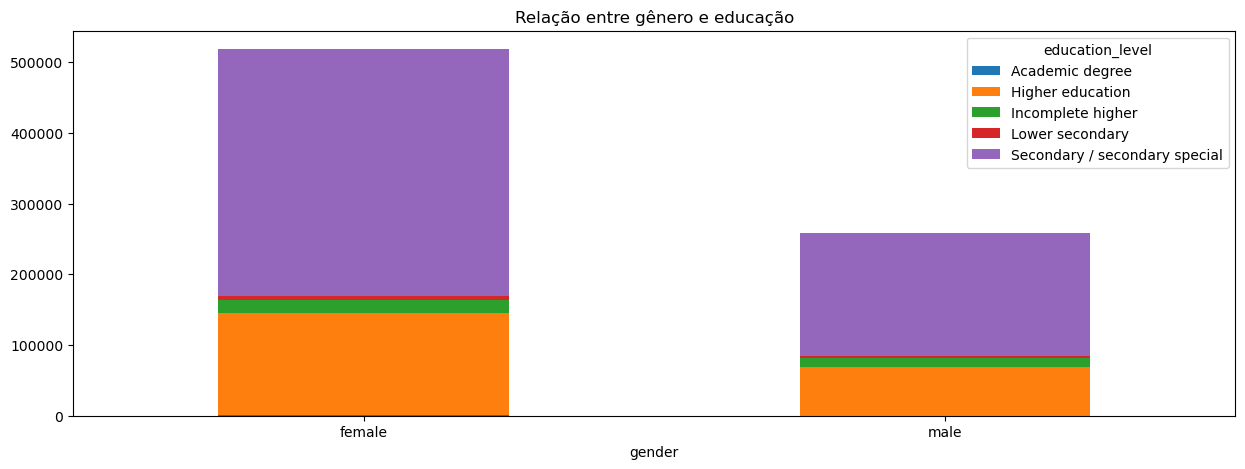

In [42]:
# traçando a contagem de valor da educação versus gênero
df.groupby('gender')[['education_level']].value_counts().unstack().plot(kind='bar', figsize=(15, 5) , stacked=True)

plt.xticks(rotation=360)

plt.title('Relação entre gênero e educação')
plt.show()

#### Observações

* O conjunto de dados tem um grande número de pessoas com ensino secundário.
* O número de homens e mulheres com ensino secundário é alto.
* Além disso, o número de Lower_secondary e Academic degree é muito baixo em ambos os gêneros.
* A proporção de Lower_secondary education é semelhante para ambos os gêneros.

##### Obtendo insights sobre educação e status de empréstimo

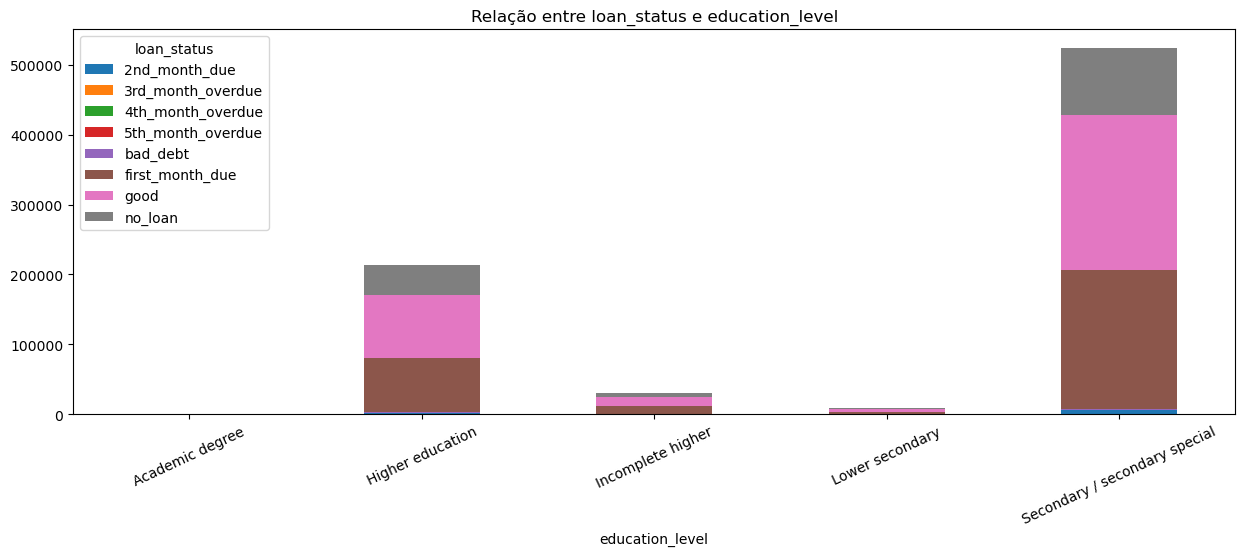

In [43]:
df.groupby('education_level')[['loan_status']].value_counts().unstack().plot(kind='bar', figsize=(15, 5) , stacked= True)
plt.title('Relação entre loan_status e education_level')
plt.xticks(rotation=25)
plt.show()

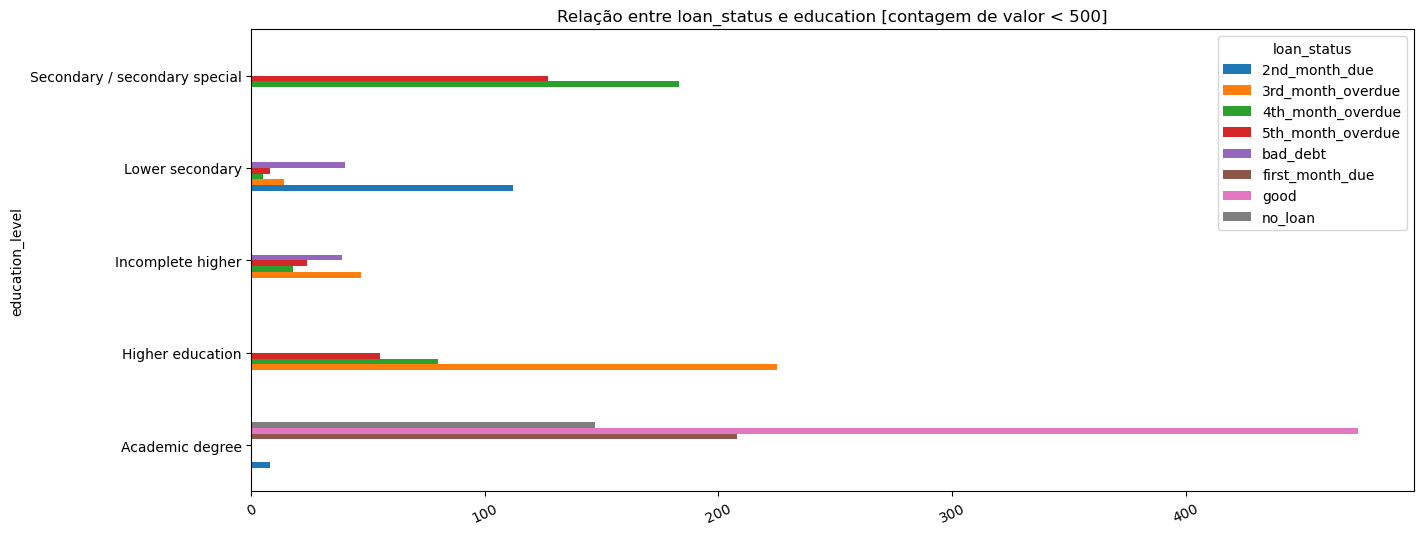

In [44]:
count = df.groupby('education_level')[['loan_status']].value_counts()

count[count<=500].unstack().plot(kind='barh' , figsize=(15, 6))

plt.title('Relação entre loan_status e education [contagem de valor < 500]')
plt.xticks(rotation=25)
plt.show()

#### Observações 

* O conjunto de dados tem um grande número de pessoas com ensino secundário, elas representam a maior quantidade de pessoas que quitaram seus empréstimos
* Uma tendência semelhante pode ser observada na educação Academic degree.
* A maioria das pessoas com bad_debt são daqueles com Lower_secondary e Incomplete higher education.

### Obtendo insights de housing_type e loan_status

In [45]:
df['housing_type'].unique()

array(['Rented apartment', 'House / apartment', 'Municipal apartment',
       'With parents', 'Co-op apartment', 'Office apartment'],
      dtype=object)

In [46]:
df['housing_type'].value_counts()

housing_type
House / apartment      697151
With parents            35735
Municipal apartment     24640
Rented apartment        10898
Office apartment         5636
Co-op apartment          3655
Name: count, dtype: int64

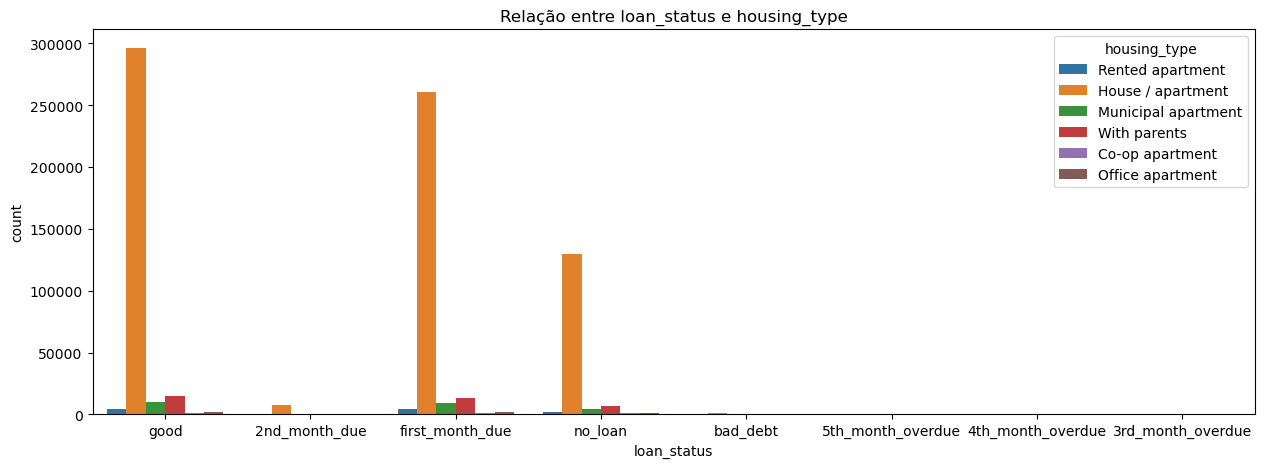

In [47]:
# verificando a relação entre loan_status e housing_type

plt.figure(figsize=(15, 5))

sns.countplot(data=df, x=df['loan_status'], hue=df['housing_type'])

plt.title('Relação entre loan_status e housing_type')

plt.show()

In [48]:
count = df.groupby(['housing_type', 'loan_status']).size()

bad_loan= count[count.index.get_level_values('loan_status') == 'bad_debt']
bad_loan

housing_type         loan_status
Co-op apartment      bad_debt         16
House / apartment    bad_debt       1368
Municipal apartment  bad_debt         54
Office apartment     bad_debt         14
Rented apartment     bad_debt         29
With parents         bad_debt         46
dtype: int64

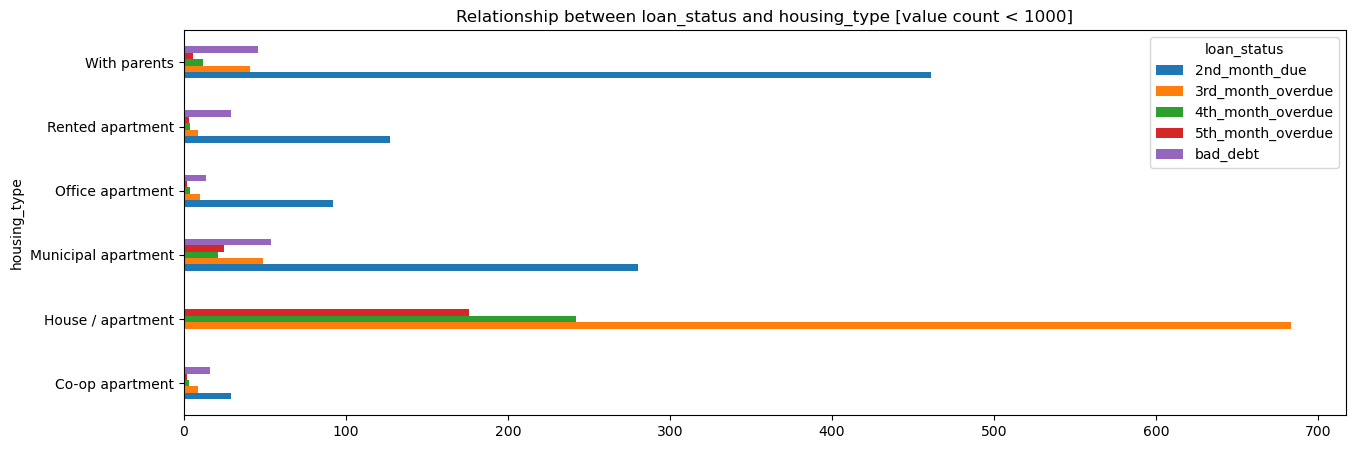

In [49]:
# plotando a contagem de valores < 1000 de housing_type e loan_status

count = df.groupby(['housing_type', 'loan_status']).size()
count[count<1000].unstack().plot(kind='barh' , figsize=(15, 5) , legend=True )

plt.title('Relationship between loan_status and housing_type [value count < 1000]')

plt.show()


#### Observações

* A maioria das pessoas que possuem sua própria casa tem good, first month due e no_loan em loan_status, o que é uma tendência positiva.
* As pessoas que moram com os pais têm a maior participação em 2nd_month_due de loan_status. Essa tendência é seguida, respectivamente, por Municipal apartment, Rented apartment e With office apartment.
* As pessoas com o menor número de bad_debt em loan_status são dos tipos de moradia office apartment e co apartment.

#### Obtendo insights de family_members e loan_status

In [50]:
df.family_members.value_counts()

family_members
2.0     423723
1.0     141477
3.0     134894
4.0      66990
5.0       8999
6.0       1196
7.0        273
15.0       111
9.0         46
20.0         6
Name: count, dtype: int64

In [51]:
# verificando a relação entre loan_status e family_members
df.groupby('family_members')[['loan_status']].value_counts().unstack()

loan_status,2nd_month_due,3rd_month_overdue,4th_month_overdue,5th_month_overdue,bad_debt,first_month_due,good,no_loan
family_members,,,,,,,,
1.0,1651.0,179.0,71.0,52.0,239.0,53411.0,59894.0,25980.0
2.0,4571.0,414.0,161.0,108.0,808.0,157392.0,181131.0,79138.0
3.0,1528.0,132.0,34.0,34.0,381.0,50885.0,54889.0,27011.0
4.0,858.0,54.0,15.0,18.0,92.0,25110.0,29037.0,11806.0
5.0,108.0,21.0,4.0,1.0,5.0,3234.0,4068.0,1558.0
6.0,16.0,1.0,1.0,1.0,2.0,463.0,442.0,270.0
7.0,NaN,NaN,NaN,NaN,NaN,57.0,53.0,163.0
9.0,10.0,NaN,NaN,NaN,NaN,14.0,22.0,NaN
15.0,5.0,NaN,NaN,NaN,NaN,82.0,NaN,24.0


#### Obsevações

* A maioria dos clientes tem 2 membros na família.
* O loan_status dos usuários de atm é good, first month due e no_loan para aqueles que têm 1, 2 ou 3 membros na família, o que é uma tendência positiva.
* Por outro lado, o número de pessoas com loan_status = 2nd month due é relativamente alto para aqueles com 2 membros na família.

##### Verificando a relação entre contagem de filhos e loan_status

In [52]:
df.num_children.value_counts()

num_children
0     540639
1     155638
2      70399
3       9328
4       1224
5        324
14       111
7         46
19         6
Name: count, dtype: int64

In [53]:
# verificando a relação entre loan_status e contagem de filhos
df.groupby('num_children')[['loan_status']].value_counts().unstack()

loan_status,2nd_month_due,3rd_month_overdue,4th_month_overdue,5th_month_overdue,bad_debt,first_month_due,good,no_loan
num_children,,,,,,,,
0,5908.0,559.0,213.0,146.0,994.0,201794.0,230268.0,100757.0
1,1801.0,156.0,51.0,46.0,434.0,58550.0,64120.0,30480.0
2,888.0,64.0,17.0,20.0,92.0,26171.0,30485.0,12662.0
3,119.0,21.0,4.0,1.0,5.0,3468.0,4143.0,1567.0
4,16.0,1.0,1.0,1.0,2.0,490.0,416.0,297.0
5,NaN,NaN,NaN,NaN,NaN,79.0,82.0,163.0
7,10.0,NaN,NaN,NaN,NaN,14.0,22.0,NaN
14,5.0,NaN,NaN,NaN,NaN,82.0,NaN,24.0
19,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN


##### Obtendo insights do employment_in_days

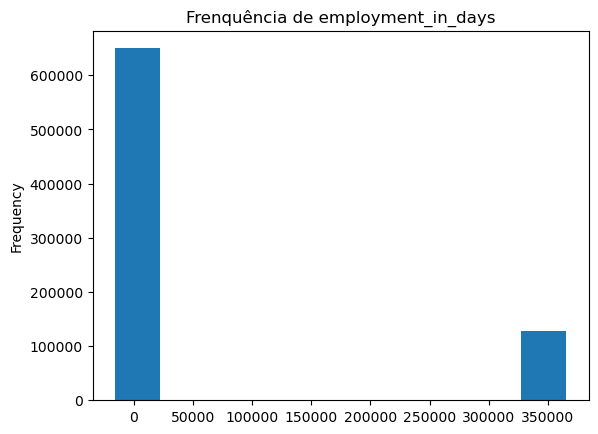

In [54]:
df['employment_in_days'].plot(kind = 'hist')
plt.title('Frenquência de employment_in_days')
plt.show()


In [55]:
# # Filtrando DataFrame onde employment_in_days > 0 para mostrar a contagem de desemprego
df[df['employment_in_days'] > 0].value_counts().sum()

np.int64(127972)

#### Obeservações

* O valor em employment in days maior que 0 indica que a pessoa está desempregada.
* Temos 127.972 pessoas desempregadas.

In [56]:
# Verificando a relação entre employment_in_days > 0 (desemprego) e loan_status
filtered_df = df[df['employment_in_days'] > 0]
filtered_df.groupby('loan_status').size()

loan_status
2nd_month_due         1128
3rd_month_overdue      149
4th_month_overdue       73
5th_month_overdue       37
bad_debt               266
first_month_due      47620
good                 55172
no_loan              23527
dtype: int64

#### Observações:

* O loan_status da maioria das pessoas desempregadas é good, first month due e no_loan, o que é uma tendência positiva.
* Por outro lado, o loan_status de bad_debt para pessoas desempregadas é muito baixo.

# Data Preprocessing 

In [57]:
df.columns

Index(['ID', 'gender', 'owns_car', 'owns_property', 'num_children',
       'total_income', 'income_type', 'education_level', 'family_status',
       'housing_type', 'age_in_days', 'employment_in_days', 'mobile',
       'work_phone', 'phone', 'email', 'family_members', 'months_balance',
       'status', 'loan_status'],
      dtype='object')

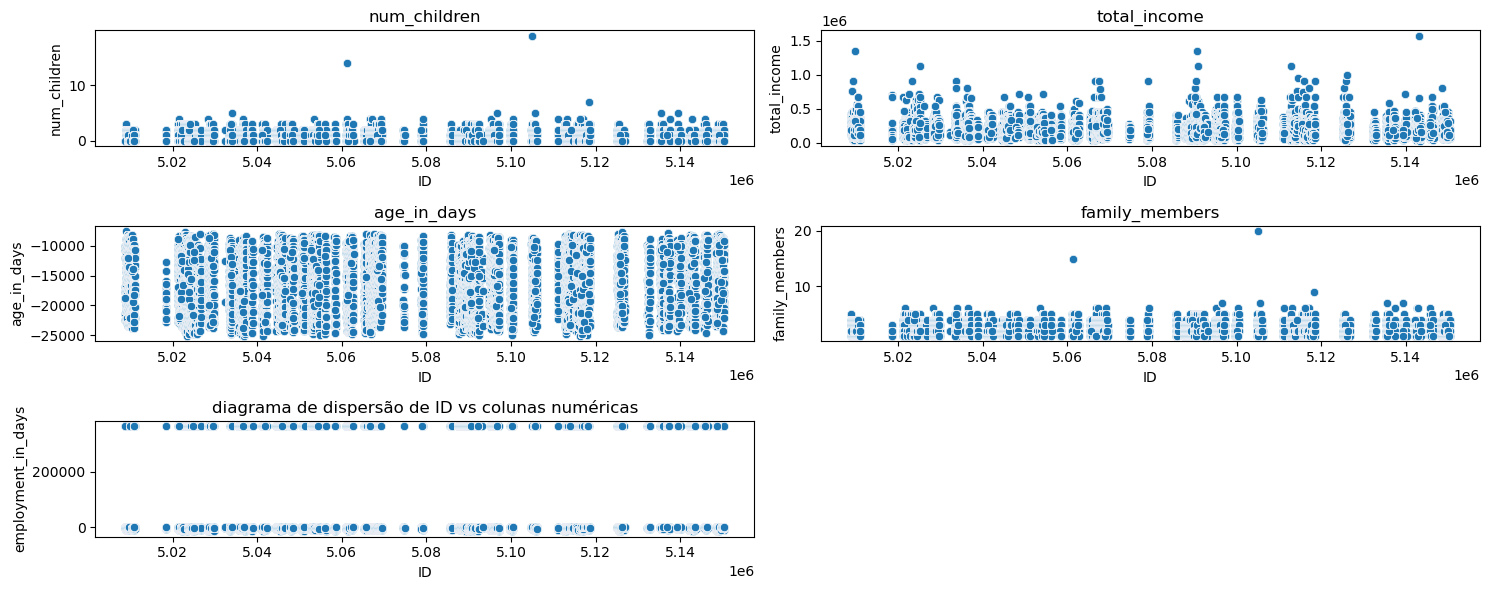

In [58]:
col_num = ['num_children', 'total_income', 'age_in_days',  'family_members' , 'employment_in_days']

plt.figure(figsize=(15, 6))


for i in range(len(col_num)):
    plt.subplot(3, 2, i+1)
    plt.title(col_num[i])
    sns.scatterplot(data=df, y=col_num[i], x='ID')
plt.title('diagrama de dispersão de ID vs colunas numéricas')
plt.tight_layout()
plt.show()

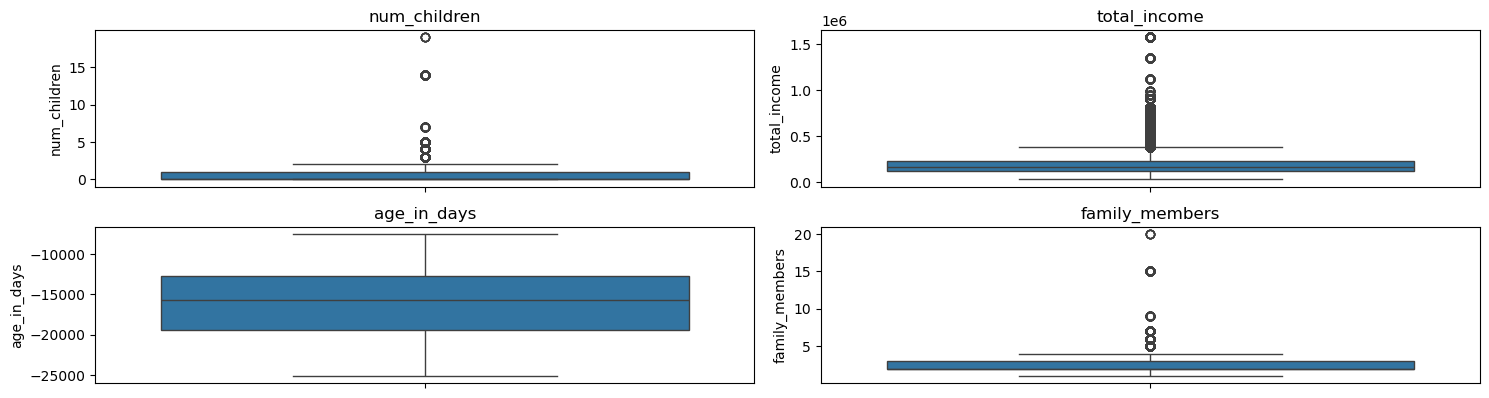

In [59]:
col = ['num_children', 'total_income', 'age_in_days',  'family_members' ]

plt.figure(figsize=(15, 6))

for i in range(len(col)):
    plt.subplot(3, 2, i+1)
    plt.title(col[i])  
    sns.boxplot(data=df, y=col[i])

plt.tight_layout()
plt.show()

#### Observações:

* Como podemos ver, existem outliers presentes em três colunas:
  * total_income
  * num_children
  * family_members
* Tanto o scatter plot quanto o box plot mostram outliers nessas colunas mencionadas.

##### Removendo outliers de  ['num_children', 'total_income' , 'family_members']

In [60]:
# Removendo outliers

col_out = ['num_children', 'total_income' , 'family_members']

for i in range(len(col_out)):

    q1 = df[col_out[i]].quantile(0.25)
    q3 = df[col_out[i]].quantile(0.75)

    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
 
    df[col_out[i]] = np.where((df[col_out[i]] >= upper_bound) | (df[col_out[i]] <= lower_bound), df[col_out[i]].median() , df[col_out[i]])

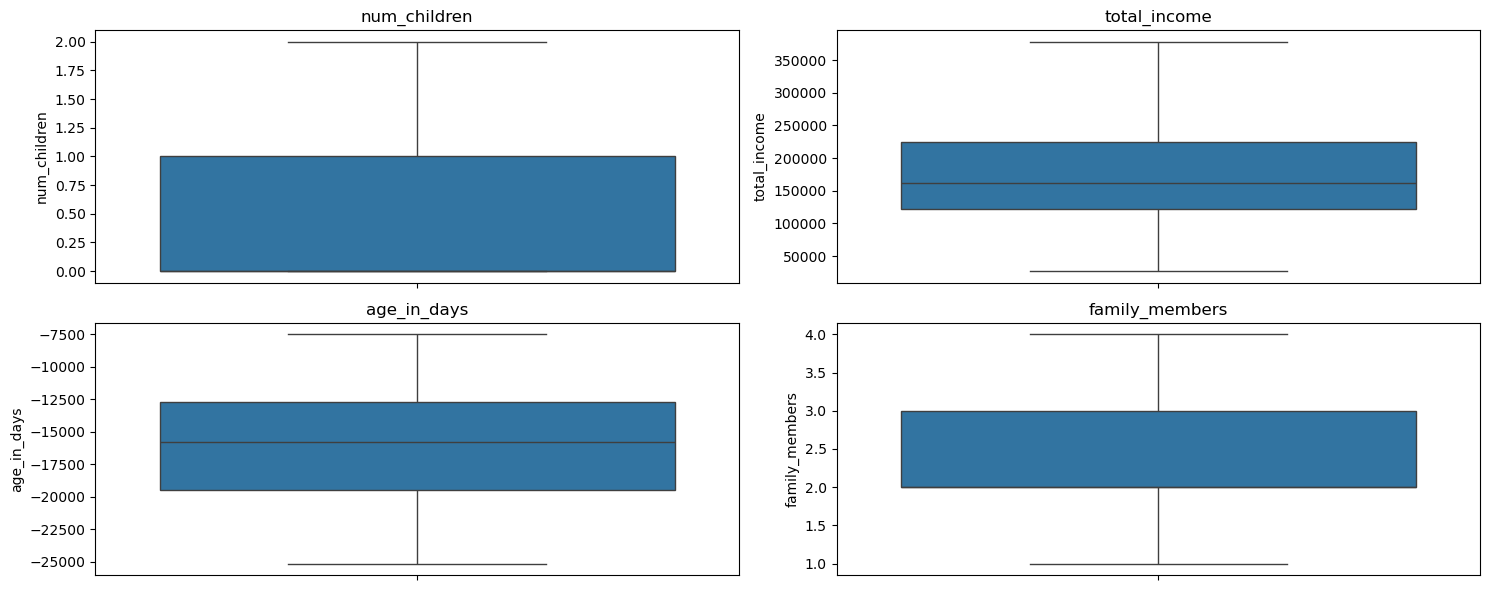

In [61]:
# Confirmando remoção dos outliers

col = ['num_children', 'total_income', 'age_in_days',  'family_members']

plt.figure(figsize=(15, 6))

for i in range(len(col)):
    plt.subplot(2, 2, i+1)
    plt.title(col[i]) 
    sns.boxplot(data=df, y=col[i])

plt.tight_layout()
plt.show()

##### Padronização

In [62]:
col = ['num_children', 'total_income', 'age_in_days',  'family_members']

sc = StandardScaler()
for i in col:
    df[i] = sc.fit_transform(df[[i]])

# Adequação do modelo[Random Forest Classifier]

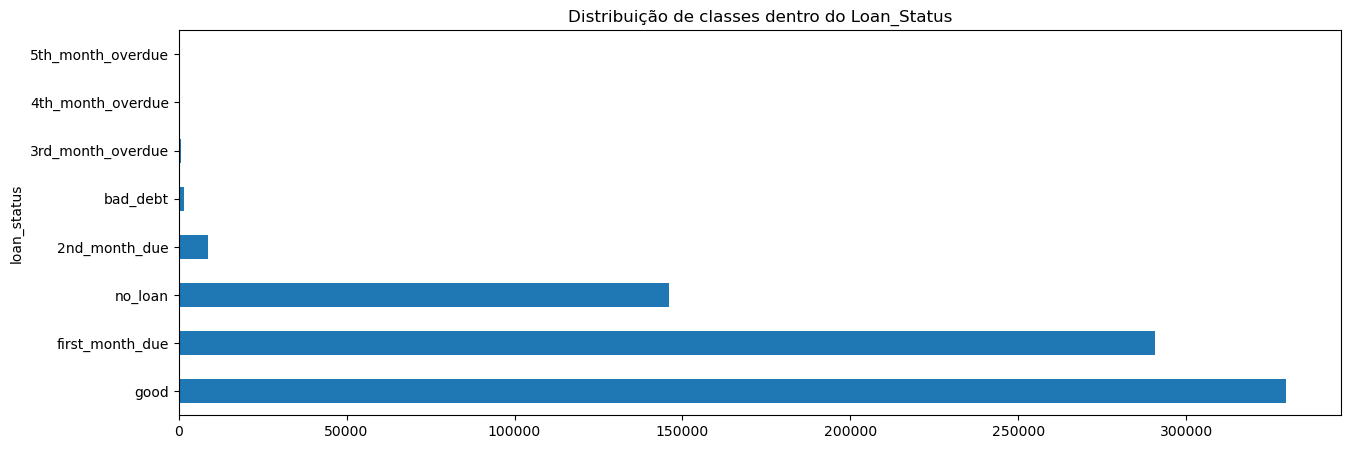

In [63]:
# verificando a distribuição do loan_status
df.loan_status.value_counts().plot(kind='barh', figsize=(15, 5))
plt.title('Distribuição de classes dentro do Loan_Status')
plt.show()

#### Observações:

* O loan_status é nossa variável alvo.
* Ao analisar a distribuição das classes da nossa variável alvo loan_status, podemos ver que ela está altamente desbalanceada.

In [64]:
df.head()

,ID,gender,owns_car,owns_property,num_children,total_income,income_type,education_level,family_status,housing_type,age_in_days,employment_in_days,mobile,work_phone,phone,email,family_members,months_balance,status,loan_status
0,5008804,male,yes,yes,-0.590317,-0.168401,Working,Higher education,Civil marriage,Rented apartment,1.00381,-4542,1,1,0,0,-0.199667,0,C,good
1,5008804,male,yes,yes,-0.590317,-0.168401,Working,Higher education,Civil marriage,Rented apartment,1.00381,-4542,1,1,0,0,-0.199667,-1,C,good
2,5008804,male,yes,yes,-0.590317,-0.168401,Working,Higher education,Civil marriage,Rented apartment,1.00381,-4542,1,1,0,0,-0.199667,-2,C,good
3,5008804,male,yes,yes,-0.590317,-0.168401,Working,Higher education,Civil marriage,Rented apartment,1.00381,-4542,1,1,0,0,-0.199667,-3,C,good
4,5008804,male,yes,yes,-0.590317,-0.168401,Working,Higher education,Civil marriage,Rented apartment,1.00381,-4542,1,1,0,0,-0.199667,-4,C,good


# Label Encoder

In [65]:
# Filtrando colunas que precisam de label encoder
col = ['gender', 'owns_car', 'owns_property', 'income_type','education_level', 'family_status', 'housing_type', 'status']

labelencoder =  LabelEncoder()

for i in col:
    df[i] =labelencoder.fit_transform(df[i] )

In [66]:
# Pré-visualinzado conjunto de dados após label encoder
df.head() 

,ID,gender,owns_car,owns_property,num_children,total_income,income_type,education_level,family_status,housing_type,age_in_days,employment_in_days,mobile,work_phone,phone,email,family_members,months_balance,status,loan_status
0,5008804,1,1,1,-0.590317,-0.168401,4,1,0,4,1.00381,-4542,1,1,0,0,-0.199667,0,6,good
1,5008804,1,1,1,-0.590317,-0.168401,4,1,0,4,1.00381,-4542,1,1,0,0,-0.199667,-1,6,good
2,5008804,1,1,1,-0.590317,-0.168401,4,1,0,4,1.00381,-4542,1,1,0,0,-0.199667,-2,6,good
3,5008804,1,1,1,-0.590317,-0.168401,4,1,0,4,1.00381,-4542,1,1,0,0,-0.199667,-3,6,good
4,5008804,1,1,1,-0.590317,-0.168401,4,1,0,4,1.00381,-4542,1,1,0,0,-0.199667,-4,6,good


# Selecionando melhores features: Random Forest Classifier

##### Matriz de correlação para características numéricas

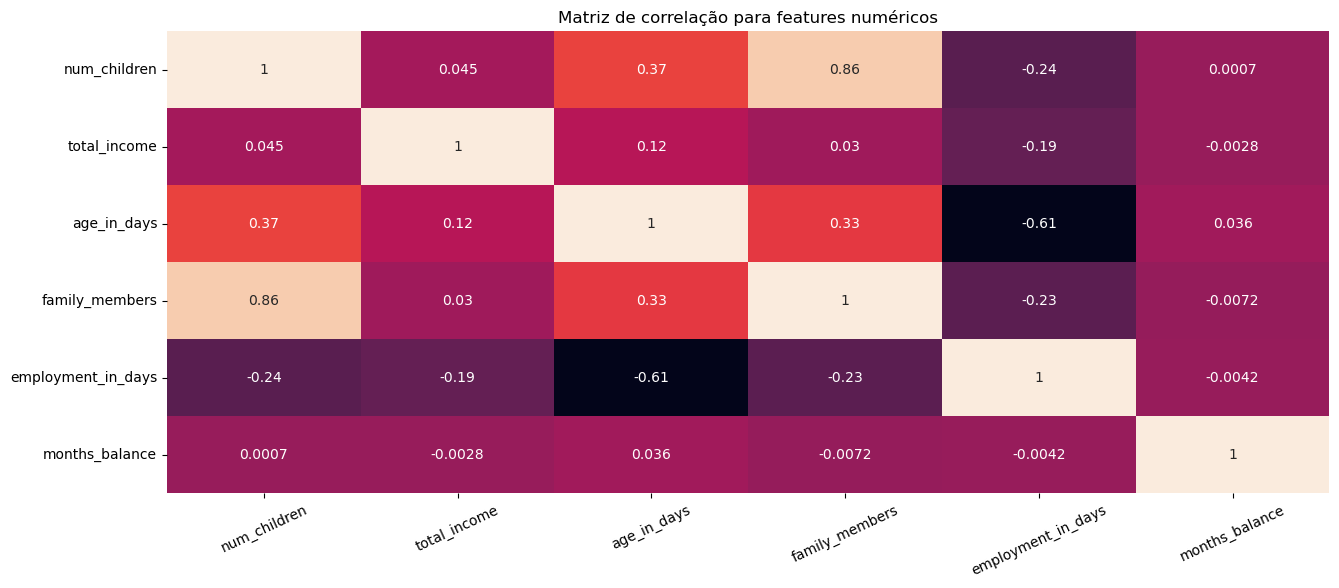

In [67]:
# matriz de correlação

plt.figure(figsize=(15, 6))

sns.heatmap(df[['num_children', 'total_income', 'age_in_days',  'family_members', 'employment_in_days', 'months_balance']].corr(), annot=True , cbar=False) 

plt.xticks(rotation=25)
plt.title('Matriz de correlação para features numéricos')
plt.show()

#### Observações:

*  children e family_members são altamente correlacionados entre si.
* No entanto, não há uma correlação forte entre outras variáveis numéricas.

In [68]:
# Verificando a existência de multicolinearidade

col = df.drop(['loan_status', 'status'], axis=1)


factor  = pd.DataFrame(columns=["VIF", "Features"] )
factor["Features"] = col.columns
factor["VIF"] = [variance_inflation_factor(col.values, i) for i in range(col.shape[1])]

factor

,VIF,Features
0,1.019165,ID
1,1.240486,gender
2,1.218307,owns_car
3,1.096036,owns_property
4,12.236508,num_children
5,1.165436,total_income
6,1.187861,income_type
7,1.090580,education_level
8,4.476697,family_status
9,1.072517,housing_type


#### Observações

* A multicolinearidade ocorre quando duas ou mais variáveis preditoras no modelo são altamente correlacionadas.
* O Variance Inflation Factor (VIF) é 1.0 para todas as colunas, exceto num_children, family_status e mobile, que são altamente correlacionadas entre si.
* Além disso, as colunas children e family_status são altamente correlacionadas.
* Portanto, será preciso remover as colunas children, family_status e mobile da nossa lista de variáveis independentes para obter os melhores resultados com o Random Forest Classifier.

# Construção de Modelo

In [69]:
# Dividindo o conjunto de dados entre features e labels

X = df.drop(['loan_status' , 'status', 'num_children' , 'family_members', 'mobile'], axis=1)

y = df['loan_status']

In [70]:
X.columns

Index(['ID', 'gender', 'owns_car', 'owns_property', 'total_income',
       'income_type', 'education_level', 'family_status', 'housing_type',
       'age_in_days', 'employment_in_days', 'work_phone', 'phone', 'email',
       'months_balance'],
      dtype='object')

In [71]:
X.head()

,ID,gender,owns_car,owns_property,total_income,income_type,education_level,family_status,housing_type,age_in_days,employment_in_days,work_phone,phone,email,months_balance
0,5008804,1,1,1,-0.168401,4,1,0,4,1.00381,-4542,1,0,0,0
1,5008804,1,1,1,-0.168401,4,1,0,4,1.00381,-4542,1,0,0,-1
2,5008804,1,1,1,-0.168401,4,1,0,4,1.00381,-4542,1,0,0,-2
3,5008804,1,1,1,-0.168401,4,1,0,4,1.00381,-4542,1,0,0,-3
4,5008804,1,1,1,-0.168401,4,1,0,4,1.00381,-4542,1,0,0,-4


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [73]:
model = RandomForestClassifier()

In [74]:
model.fit(X_train, y_train )

RandomForestClassifier()

In [75]:
y_pred = model.predict(X_test)

In [76]:
# Criando um dataframe para comparar os valores reais com o previsto
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(10)

,Actual,Predicted
719660,good,good
697010,no_loan,no_loan
441561,first_month_due,first_month_due
131612,good,good
582915,first_month_due,first_month_due
165696,no_loan,no_loan
198875,first_month_due,first_month_due
201284,no_loan,no_loan
19537,good,good
83660,good,good


In [77]:
print(f'Taxa de acurácia : {accuracy_score(y_test, y_pred)*100:.2f} %')

Taxa de acurácia : 87.47 %


In [78]:
print(f"Precisão : {precision_score(y_test, y_pred, average = 'micro'):.2f}")

Precisão : 0.87


In [79]:
print(f"F1-Score : {f1_score(y_test, y_pred , average='micro')}")

F1-Score : 0.8747187279000493


In [80]:
# relatório de classificação
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

    2nd_month_due       0.32      0.25      0.28      2679
3rd_month_overdue       0.17      0.14      0.15       238
4th_month_overdue       0.08      0.06      0.07        95
5th_month_overdue       0.11      0.10      0.10        62
         bad_debt       0.90      0.85      0.87       446
  first_month_due       0.84      0.86      0.85     87212
             good       0.94      0.95      0.94     98675
          no_loan       0.83      0.78      0.80     43908

         accuracy                           0.87    233315
        macro avg       0.52      0.50      0.51    233315
     weighted avg       0.87      0.87      0.87    233315



#### Taxa de acerto

* A taxa de acurácia é basicamente a porcentagem de previsões corretas feitas pelo modelo dentre todas as previsões
  * (ou seja, o número de previsões corretas dividido pelo número total de previsões)

O valor da taxa de acurácia varia de 0 a 1 (100%).
A pontuação de precisão do nosso modelo é de 87.47%, o que é muito bom


#### Taxa de precisão 

* A taxa de precisão é basicamente a porcentagem de previsões positivas corretas feitas pelo modelo
  * Fórmula: Precisão = TP / (TP + FP)
  * (ou seja, o número de previsões positivas corretas dividido pelo número total de previsões positivas)
* O valor da taxa de precisão varia de 0 a 1.
* Calcular a pontuação de precisão do modelo usando o parâmetro average = 'micro' que calcula a pontuação de precisão globalmente considerando o número total de verdadeiros positivos, falsos positivos e falsos negativos em todas as classes. Ele trata todas as instâncias (amostras) igualmente, independentemente de seus rótulos de classe.

#### Recall Score

* Recall é basicamente a porcentagem de previsões positivas corretas feitas pelo modelo.
  * Fórmula: Recall = TP / (TP + FN)
  * (ou seja, o número de previsões positivas corretas dividido pelo total de previsões positivas reais).
* O valor do recall varia de 0 a 1.
* O Recall score do modelo é 0.87, o que indica que o número de falsos negativos é baixo.

### F1-Score

* F1-Score é basicamente a média harmônica entre a precisão e o recall.
  * Fórmula: Formula: F1 = 2 * (precision * recall) / (precision + recall)
* É útil quando temos classes desequilibradas em nosso conjunto de dados e fornece os melhores resultados ao incluir precisão e recall.